In [5]:
# from future import print_function
import os
import torch
import torch.optim as optim
import torch.backends.cudnn as cudnn
import argparse
import torch.utils.data as data
from data import WiderFaceDetection, detection_collate, preproc, cfg_mnet, cfg_re50
from layers.modules import MultiBoxLoss
from layers.functions.prior_box import PriorBox
import time
import datetime
import math
from models.retinaface import RetinaFace
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

print(f"Using device: {device}")

In [7]:
# Declare config (use resnet50 backbone)
cfg = cfg_re50
rgb_mean = (104, 117, 123) # bgr order
num_classes = 2
img_dim = cfg['image_size']
num_gpu = cfg['ngpu']
batch_size = cfg['batch_size']
max_epoch = cfg['epoch']
gpu_train = cfg['gpu_train']

initial_lr = 1e-3
momentum = 0.9
weight_decay = 5e-4

In [8]:
# Instantiate model with the configurations above
net = RetinaFace(cfg=cfg).to(device)
net.train()

/Users/calvin/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/calvin/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/calvin/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 25.9MB/s]


RetinaFace(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seque

In [9]:
# Load an image for viewing
img = Image.open("monke.jpg")
img = np.array(img)

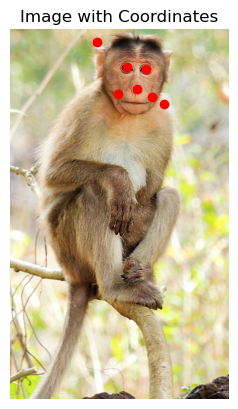

In [12]:
# This code is for locating landmarks on the monkey's face
coordinates = [(140, 20), (250, 120), (190, 60), (175, 105), (205, 96), (220, 63), (230, 110)]  # (x, y) format

plt.imshow(img)
plt.axis('off')

# Plot the coordinates
for coord in coordinates:
    plt.plot(coord[0], coord[1], 'ro')  # 'ro' means red circle

# Display the result
plt.title("Image with Coordinates")
plt.show()

In [13]:
# Load an image to use for FGSM
img = Image.open("monke.jpg")
img = np.array(img)

In [14]:
# Define targets
annotations = np.zeros((0, 15))
annotation = np.zeros((1, 15))
# bbox
annotation[0, 0] = 140  # x1
annotation[0, 1] = 20  # y1
annotation[0, 2] = 110  # x2
annotation[0, 3] = 100  # y2

# landmarks
annotation[0, 4] = 190    # l0_x
annotation[0, 5] = 60    # l0_y
annotation[0, 6] = 175    # l1_x
annotation[0, 7] = 105    # l1_y
annotation[0, 8] = 205   # l2_x
annotation[0, 9] = 96   # l2_y
annotation[0, 10] = 220  # l3_x
annotation[0, 11] = 63  # l3_y
annotation[0, 12] = 230  # l4_x
annotation[0, 13] = 110  # l4_y
annotations = np.append(annotations, annotation, axis=0)
target = np.array(annotations)

In [15]:
preproc_inst = preproc(img_dim, rgb_mean)
img, target = preproc_inst(img, target)

In [17]:
print(torch.cuda.is_available())

False


In [16]:
# Image and Label processing
# Add batch dimension for images
target = torch.Tensor(target)
target = target.unsqueeze(0)
img = torch.Tensor(img)
img = img.unsqueeze(0)
img = img.cuda()
img.requires_grad = True
targets = [anno.cuda() for anno in target]

AssertionError: Torch not compiled with CUDA enabled

In [11]:
# Initialise optimisers
optimizer = optim.SGD(net.parameters(), lr=initial_lr, momentum=momentum, weight_decay=weight_decay)
criterion = MultiBoxLoss(num_classes, 0.35, True, 0, True, 7, 0.35, False)

In [12]:
# Initialise anchor boxes for the RetinaFace model
priorbox = PriorBox(cfg, image_size=(img_dim, img_dim))
with torch.no_grad():
    priors = priorbox.forward()
    priors = priors.cuda()

In [13]:
# Save a copy of the original image to be modified by the gradients later in FGSM
x_adv = img.detach().clone()
x_adv.requires_grad = True

In [14]:
# FGSM Attack
# Forward
out = net(img)
print(targets)
# backprop
optimizer.zero_grad()
loss_l, loss_c, loss_landm = criterion(out, priors, targets)
loss = cfg['loc_weight'] * loss_l + loss_c + loss_landm
loss.backward()

[tensor([[0.8167, 0.0333, 0.7667, 0.1667, 0.7083, 0.1750, 0.6833, 0.1000, 0.6583,
         0.1600, 0.6167, 0.1833, 0.6333, 0.1050, 0.0000]], device='cuda:0')]


In [19]:
# FGSM Attack
eps = 0.05
grad_data = img.grad.data
x_adv = torch.clamp(x_adv - eps * grad_data.sign(), 0, 1).detach()

# Check whether the attack is successful
pred_adv = net(x_adv)
print(pred_adv)

(tensor([[[ 0.3287,  0.1941, -0.1484,  0.2972],
         [-0.5113,  0.4588, -0.3130,  0.2696],
         [-0.3476, -0.1778, -0.2210,  0.7243],
         ...,
         [-0.2214,  0.3970, -0.7793, -0.4505],
         [ 0.1900, -0.1606,  0.3692,  0.3561],
         [ 0.1344,  0.4139, -0.3260, -0.6549]]], device='cuda:0',
       grad_fn=<CatBackward0>), tensor([[[-0.2550,  0.3606],
         [-0.0748,  0.0890],
         [-0.0050,  0.9429],
         ...,
         [-0.6213,  0.7860],
         [-0.2514, -0.2268],
         [-0.3057,  0.9113]]], device='cuda:0', grad_fn=<CatBackward0>), tensor([[[-0.4792,  0.4501,  0.0102,  ...,  0.3998, -0.1097,  0.0370],
         [ 0.1159,  0.1853, -0.6608,  ..., -0.0943, -0.2413,  0.1274],
         [ 0.1258,  0.2762, -0.1782,  ...,  0.1974, -0.0335,  0.1651],
         ...,
         [-0.0289,  0.0139,  0.5790,  ...,  0.6890,  0.2171, -0.2899],
         [ 0.3694,  0.7296,  0.0797,  ...,  1.0302,  0.5227,  0.2831],
         [-0.3527,  1.0638,  0.4747,  ...,  0.3455,